In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import cv2
from skimage import io


In [ ]:
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import tensorflow.keras.backend as K

In [ ]:

import random
import glob
from sklearn.preprocessing import StandardScaler, normalize
from IPython.display import display

In [5]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/lgg-mri-segmentation/kaggle_3m/data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Patient                    110 non-null    object 
 1   RNASeqCluster              92 non-null     float64
 2   MethylationCluster         109 non-null    float64
 3   miRNACluster               110 non-null    int64  
 4   CNCluster                  108 non-null    float64
 5   RPPACluster                98 non-null     float64
 6   OncosignCluster            105 non-null    float64
 7   COCCluster                 110 non-null    int64  
 8   histological_type          109 non-null    float64
 9   neoplasm_histologic_grade  109 non-null    float64
 10  tumor_tissue_site          109 non-null    float64
 11  laterality                 109 non-null    float64
 12  tumor_location             109 non-null    float64
 13  gender                     109 non-null    float64

In [6]:
data_map = []
for sub_dir_path in glob.glob("/content/drive/MyDrive/Colab Notebooks/lgg-mri-segmentation/kaggle_3m/"+"*"):
    try:
        dir_name = sub_dir_path.split('/')[-1]
        for filename in os.listdir(sub_dir_path):
            image_path = sub_dir_path + '/' + filename
            data_map.extend([dir_name, image_path])
    except Exception as e:
        print(e)
      

[Errno 20] Not a directory: '/content/drive/MyDrive/Colab Notebooks/lgg-mri-segmentation/kaggle_3m/data.csv'
[Errno 20] Not a directory: '/content/drive/MyDrive/Colab Notebooks/lgg-mri-segmentation/kaggle_3m/README.md'


In [7]:
df = pd.DataFrame({"patient_id" : data_map[::2],
                   "path" : data_map[1::2]})
df.head()

,patient_id,path
0,TCGA_HT_A5RC_19990831,/content/drive/MyDrive/Colab Notebooks/lgg-mri...
1,TCGA_HT_A5RC_19990831,/content/drive/MyDrive/Colab Notebooks/lgg-mri...
2,TCGA_HT_A5RC_19990831,/content/drive/MyDrive/Colab Notebooks/lgg-mri...
3,TCGA_HT_A5RC_19990831,/content/drive/MyDrive/Colab Notebooks/lgg-mri...
4,TCGA_HT_A5RC_19990831,/content/drive/MyDrive/Colab Notebooks/lgg-mri...


In [8]:
df_imgs = df[~df['path'].str.contains("mask")]
df_masks = df[df['path'].str.contains("mask")]


# Data sorting

imgs = sorted(df_imgs["path"].values, key=lambda x : int(x.split('_')[-1].split('.')[0]))
masks = sorted(df_masks["path"].values, key=lambda x : int(x.split('_')[-2]))

# Sorting check
idx = random.randint(0, len(imgs)-1)
print("Path to the Image:", imgs[idx], "\nPath to the Mask:", masks[idx])


Path to the Image: /content/drive/MyDrive/Colab Notebooks/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_13.tif 
Path to the Mask: /content/drive/MyDrive/Colab Notebooks/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_13_mask.tif


In [9]:
# Final dataframe
brain_df = pd.DataFrame({"patient_id": df_imgs.patient_id.values,
                         "image_path": imgs,
                         "mask_path": masks
                        })
def pos_neg_diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value > 0 : 
        return 1
    else:
        return 0
    
brain_df['mask'] = brain_df['mask_path'].apply(lambda x: pos_neg_diagnosis(x))
brain_df

,patient_id,image_path,mask_path,mask
0,TCGA_HT_A5RC_19990831,/content/drive/MyDrive/Colab Notebooks/lgg-mri...,/content/drive/MyDrive/Colab Notebooks/lgg-mri...,0
1,TCGA_HT_A5RC_19990831,/content/drive/MyDrive/Colab Notebooks/lgg-mri...,/content/drive/MyDrive/Colab Notebooks/lgg-mri...,0
2,TCGA_HT_A5RC_19990831,/content/drive/MyDrive/Colab Notebooks/lgg-mri...,/content/drive/MyDrive/Colab Notebooks/lgg-mri...,0
3,TCGA_HT_A5RC_19990831,/content/drive/MyDrive/Colab Notebooks/lgg-mri...,/content/drive/MyDrive/Colab Notebooks/lgg-mri...,0
4,TCGA_HT_A5RC_19990831,/content/drive/MyDrive/Colab Notebooks/lgg-mri...,/content/drive/MyDrive/Colab Notebooks/lgg-mri...,0
...,...,...,...,...
3924,TCGA_CS_5397_20010315,/content/drive/MyDrive/Colab Notebooks/lgg-mri...,/content/drive/MyDrive/Colab Notebooks/lgg-mri...,0
3925,TCGA_CS_5397_20010315,/content/drive/MyDrive/Colab Notebooks/lgg-mri...,/content/drive/MyDrive/Colab Notebooks/lgg-mri...,0
3926,TCGA_CS_5397_20010315,/content/drive/MyDrive/Colab Notebooks/lgg-mri...,/content/drive/MyDrive/Colab Notebooks/lgg-mri...,0
3927,TCGA_CS_5397_20010315,/content/drive/MyDrive/Colab Notebooks/lgg-mri...,/content/drive/MyDrive/Colab Notebooks/lgg-mri...,0


In [10]:
import plotly.graph_objects as go  # using plotly to create interactive plots

fig = go.Figure([go.Bar(x=brain_df['mask'].value_counts().index, 
                        y=brain_df['mask'].value_counts(), 
                        width=[.4, .4]
                       )
                ])
fig.update_traces(marker_color='rgb(158,202,225)', marker_line_color='rgb(8,48,107)',
                  marker_line_width=4, opacity=0.4
                 )
fig.update_layout(title_text="Mask Count Plot",
                  width=700,
                  height=550,
                  yaxis=dict(
                             title_text="Count",
                             tickmode="array",
                             titlefont=dict(size=20)
                           )
                 )
fig.update_yaxes(automargin=True)
fig.show()

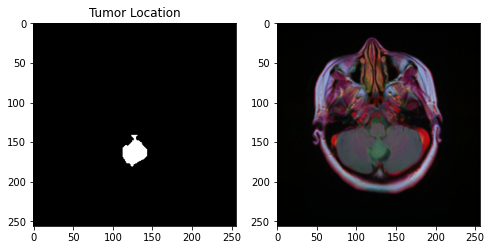

In [11]:
for i in range(len(brain_df)):
    if cv2.imread(brain_df.mask_path[i]).max() > 0:
        break

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.imshow(cv2.imread(brain_df.mask_path[i]));
plt.title('Tumor Location')

plt.subplot(1,2,2)
plt.imshow(cv2.imread(brain_df.image_path[i]));

In [12]:
cv2.imread(brain_df.mask_path[i]).max(), cv2.imread(brain_df.mask_path[i]).min()

(255, 0)

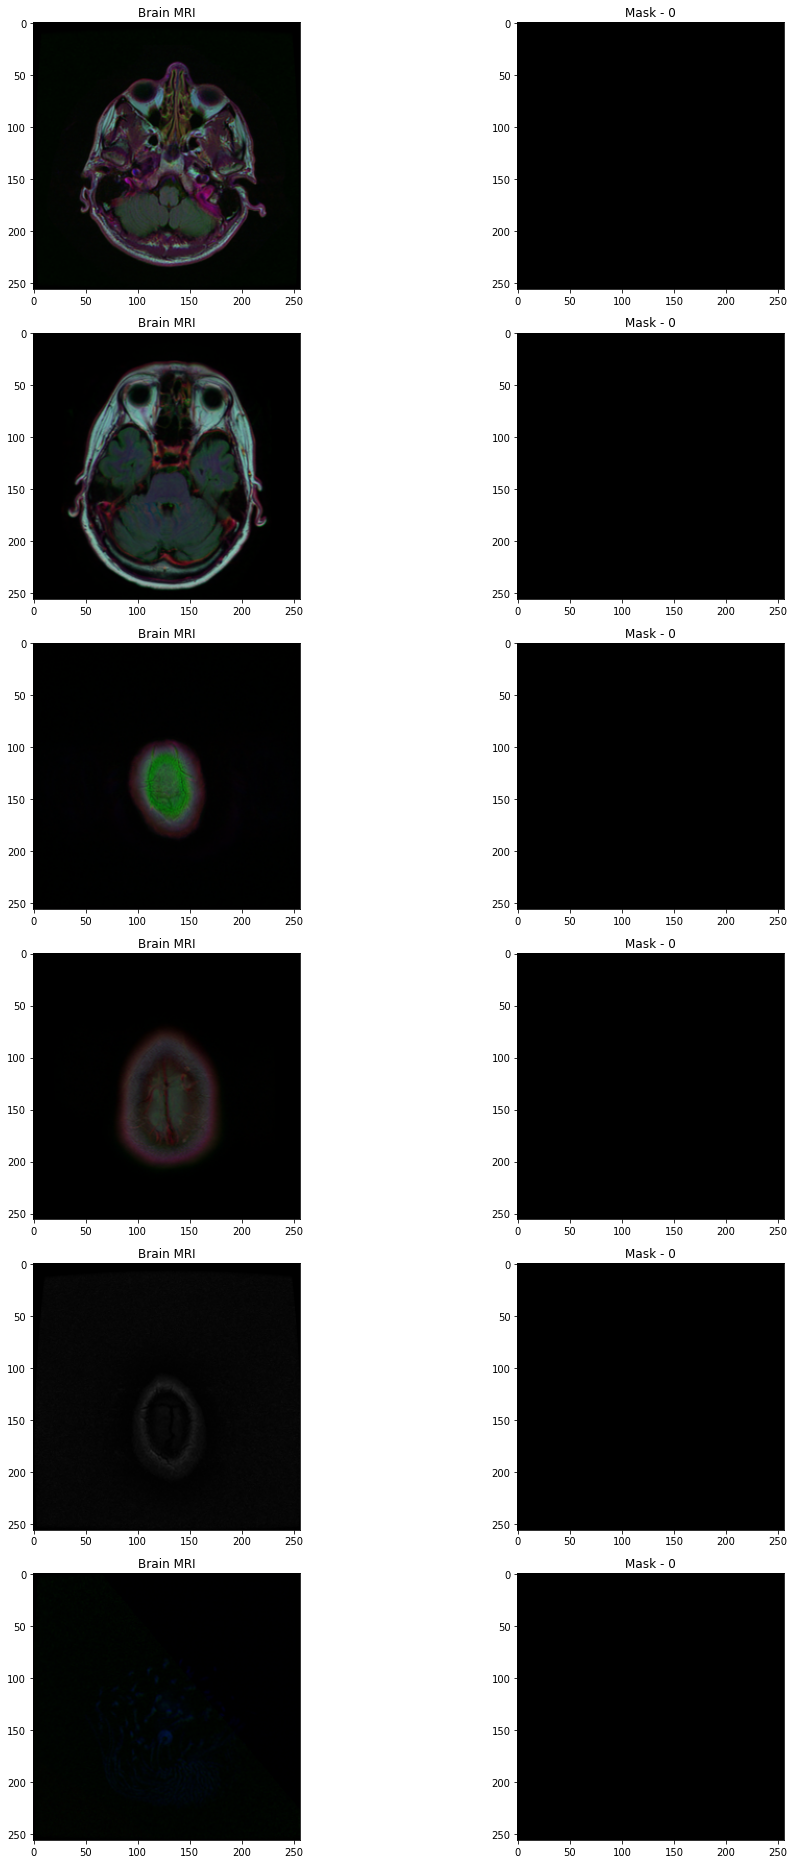

In [13]:
# Basic visualizations: Visualize the images (MRI and Mask) in the dataset separately 

fig, axs = plt.subplots(6,2, figsize=(16,26))
count = 0
for x in range(6):
  i = random.randint(0, len(brain_df)) 
  axs[count][0].title.set_text("Brain MRI") # set title
  axs[count][0].imshow(cv2.imread(brain_df.image_path[i])) # show MRI 
  axs[count][1].title.set_text("Mask - " + str(brain_df['mask'][i]))
  axs[count][1].imshow(cv2.imread(brain_df.mask_path[i])) 
  count += 1

fig.tight_layout()

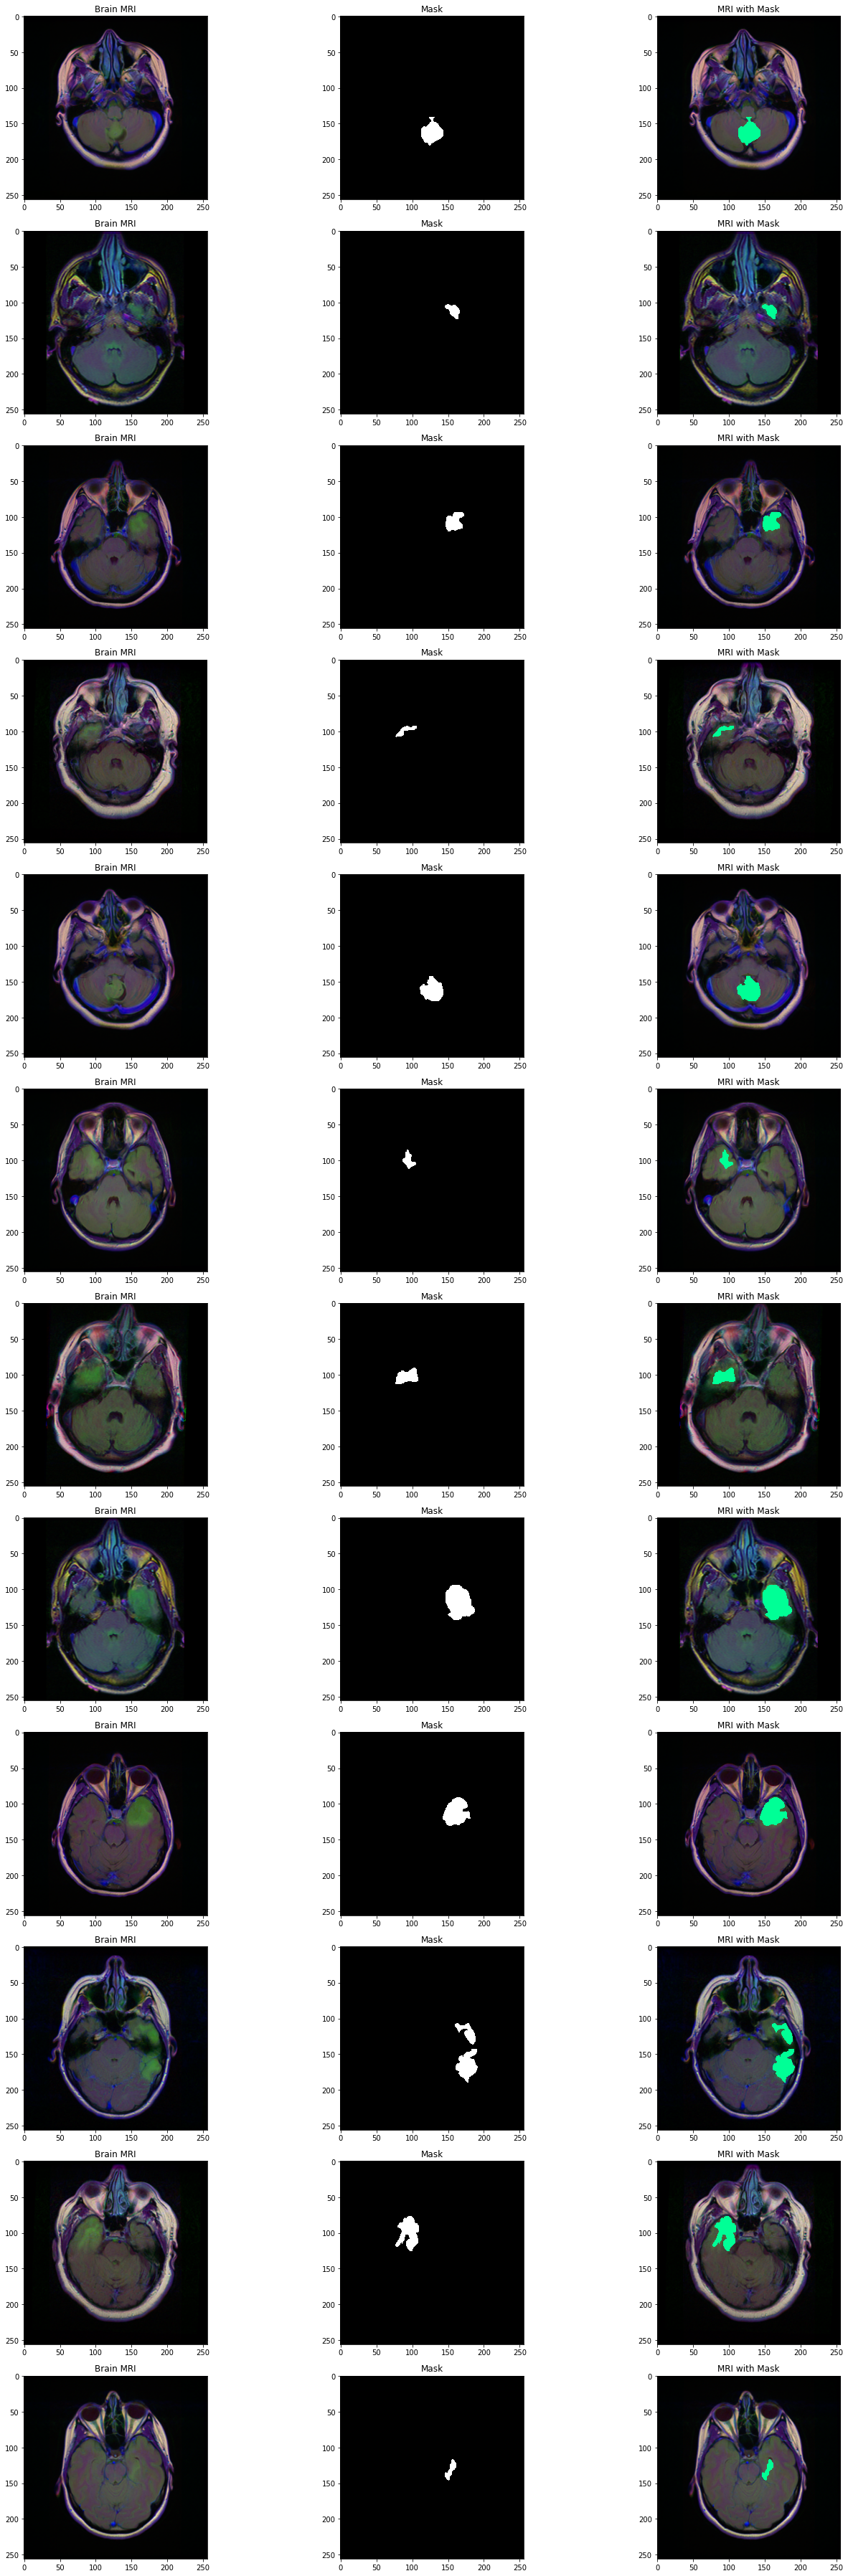

In [14]:
count = 0
i = 0
fig,axs = plt.subplots(12,3, figsize=(20,50))
for mask in brain_df['mask']:
    if (mask==1):
        img = io.imread(brain_df.image_path[i])
        axs[count][0].title.set_text("Brain MRI")
        axs[count][0].imshow(img)
        
        mask = io.imread(brain_df.mask_path[i])
        axs[count][1].title.set_text("Mask")
        axs[count][1].imshow(mask, cmap='gray')
        # change pixel color at the position of mask
        img[mask==255] = (0,255,150)  
        axs[count][2].title.set_text("MRI with Mask")
        axs[count][2].imshow(img)
        count +=1
    i += 1
    if (count==12):
        break
        
fig.tight_layout()

In [15]:
brain_df_train = brain_df.drop(columns=['patient_id'])
brain_df_train['mask'] = brain_df_train['mask'].apply(lambda x: str(x))
brain_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   mask        3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB


In [16]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(brain_df_train, test_size=0.15)


In [17]:
%pip install keras-preprocessing


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 3.9 MB/s eta 0:00:00


In [18]:
from keras_preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255., validation_split=0.1)

train_generator = datagen.flow_from_dataframe(train,
                                              directory='./',
                                              x_col='image_path',
                                              y_col='mask',
                                              subset='training',
                                              class_mode='categorical',
                                              batch_size=16,
                                              shuffle=True,
                                              target_size=(256,256)
                                             )
valid_generator = datagen.flow_from_dataframe(train,
                                              directory='./',
                                              x_col='image_path',
                                              y_col='mask',
                                              subset='validation',
                                              class_mode='categorical',
                                              batch_size=16,
                                              shuffle=True,
                                              target_size=(256,256)
                                             )
test_datagen = ImageDataGenerator(rescale=1./255.)
test_generator = test_datagen.flow_from_dataframe(test,
                                                  directory='./',
                                                  x_col='image_path',
                                                  y_col='mask',
                                                  class_mode='categorical',
                                                  batch_size=16,
                                                  shuffle=False,
                                                  target_size=(256,256)
                                                 )

Found 3006 validated image filenames belonging to 2 classes.
Found 333 validated image filenames belonging to 2 classes.
Found 590 validated image filenames belonging to 2 classes.


In [19]:
from tensorflow.keras.applications.resnet50 import ResNet50
clf_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(256,256,3)))
clf_model.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                          

In [20]:
for layer in clf_model.layers:
    layers.trainable = False

In [21]:
head = clf_model.output
head = AveragePooling2D(pool_size=(4,4))(head)
head = Flatten(name='Flatten')(head)
head = Dense(256, activation='relu')(head)
head = Dropout(0.3)(head)
head = Dense(256, activation='relu')(head)
head = Dropout(0.3)(head)
head = Dense(2, activation='softmax')(head)

model = Model(clf_model.input, head)
model.compile(loss = 'categorical_crossentropy', 
              optimizer='adam', 
              metrics= ["accuracy"]
             )
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [22]:
earlystopping = EarlyStopping(monitor='val_loss', 
                              mode='min', 
                              verbose=1, 
                              patience=15
                             )
checkpointer = ModelCheckpoint(filepath="clf-resnet-weights.hdf5", 
                               verbose=1, 
                               save_best_only=True
                              )
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=10,
                              min_delta=0.0001,
                              factor=0.2
                             )
callbacks = [checkpointer, earlystopping, reduce_lr]

In [23]:
h = model.fit(train_generator, 
              steps_per_epoch= train_generator.n // train_generator.batch_size, 
              epochs = 2, 
              validation_data= valid_generator, 
              validation_steps= valid_generator.n // valid_generator.batch_size, 
              callbacks=[checkpointer, earlystopping])                               


Epoch 1/2
187/187 [==============================] - ETA: 0s - loss: 0.6274 - accuracy: 0.7411 
Epoch 1: val_loss improved from inf to 0.62978, saving model to clf-resnet-weights.hdf5
187/187 [==============================] - 3127s 16s/step - loss: 0.6274 - accuracy: 0.7411 - val_loss: 0.6298 - val_accuracy: 0.6719
Epoch 2/2
187/187 [==============================] - ETA: 0s - loss: 0.3878 - accuracy: 0.8378 
Epoch 2: val_loss did not improve from 0.62978
187/187 [==============================] - 3016s 16s/step - loss: 0.3878 - accuracy: 0.8378 - val_loss: 0.6368 - val_accuracy: 0.6750


In [29]:
# saving model achitecture in json file
model_json = model.to_json()
with open("/content/drive/MyDrive/Colab Notebooks/clf-resnet-model.json", "w") as json_file:
    json_file.write(model_json)

In [26]:
h.history['accuracy']


[0.7411371469497681, 0.8377926349639893]

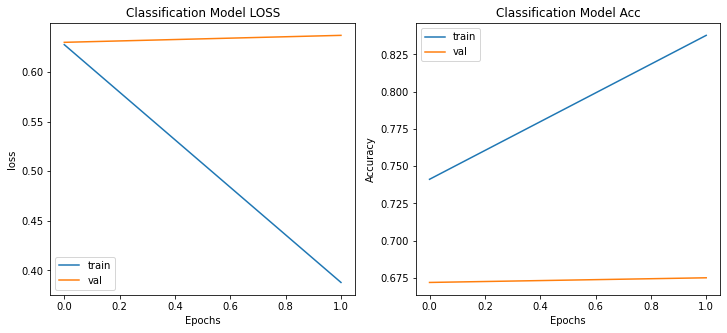

In [27]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(h.history['loss']);
plt.plot(h.history['val_loss']);
plt.title("Classification Model LOSS");
plt.ylabel("loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

plt.subplot(1,2,2)
plt.plot(h.history['accuracy']);
plt.plot(h.history['val_accuracy']);
plt.title("Classification Model Acc");
plt.ylabel("Accuracy");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

In [28]:
_, acc = model.evaluate(test_generator)
print("Test accuracy : {} %".format(acc*100))

37/37 [==============================] - 217s 6s/step - loss: 0.6463 - accuracy: 0.6559
Test accuracy : 65.59321880340576 %


37/37 [==============================] - 142s 4s/step
0.6559322033898305
              precision    recall  f1-score   support

           0       0.66      1.00      0.79       387
           1       0.00      0.00      0.00       203

    accuracy                           0.66       590
   macro avg       0.33      0.50      0.40       590
weighted avg       0.43      0.66      0.52       590



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



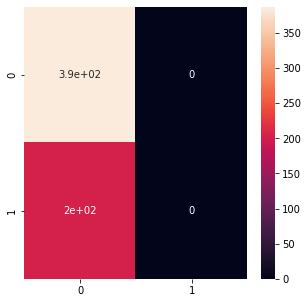

In [30]:
prediction = model.predict(test_generator)

pred = np.argmax(prediction, axis=1)
#pred = np.asarray(pred).astype('str')
original = np.asarray(test['mask']).astype('int')

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
accuracy = accuracy_score(original, pred)
print(accuracy)

cm = confusion_matrix(original, pred)

report = classification_report(original, pred, labels = [0,1])
print(report)
plt.figure(figsize = (5,5))
sns.heatmap(cm, annot=True);

# ** BUILDING A SEGMENTATION MODEL TO LOCALIZE TUMOR**

In [33]:
brain_df_mask = brain_df[brain_df['mask'] == 1]
brain_df_mask.shape

(1373, 4)

In [34]:
X_train, X_val = train_test_split(brain_df_mask, test_size=0.15)
X_test, X_val = train_test_split(X_val, test_size=0.5)
print("Train size is {}, valid size is {} & test size is {}".format(len(X_train), len(X_val), len(X_test)))

train_ids = list(X_train.image_path)
train_mask = list(X_train.mask_path)

val_ids = list(X_val.image_path)
val_mask= list(X_val.mask_path)


Train size is 1167, valid size is 103 & test size is 103
